# DOE 本番解析用 (base) v6 移動平均・メジアン

### ライブラリの一括インポート

In [41]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [42]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.setting import load_setting
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

### Matplotlib のフォント設定（オプション）

In [43]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [44]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 初期設定

In [177]:
name_doe = "doe-14a"  # 実験計画名（フォルダ名）
path_doe = os.path.join("..", "doe", f"{name_doe}.csv")

name_code = "285A"  # 銘柄コード
# name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

df_doe = pd.read_csv(path_doe)
print(df_doe)
factor_doe = list(df_doe.columns)
print(factor_doe)
col_x = factor_doe[0]
col_y = factor_doe[1]

res = AppRes()
dict_setting = load_setting(res, name_code)
df_setting = pd.DataFrame(pd.Series(dict_setting))
df_setting.columns = ["value"]
print("\n設定")
print(df_setting)

x_por = dict_setting[col_x]
y_por = dict_setting[col_y]

# 移動期間
period = 25

     PERIOD_MA_1  PERIOD_MA_2
0             30          300
1             40          300
2             50          300
3             60          300
4             70          300
..           ...          ...
164          110         1500
165          120         1500
166          130         1500
167          140         1500
168          150         1500

[169 rows x 2 columns]
['PERIOD_MA_1', 'PERIOD_MA_2']

設定
                    value
PERIOD_WARMUP      180.00
PERIOD_MA_1         50.00
PERIOD_MA_2        800.00
PERIOD_SLOPE         5.00
THRESHOLD_SLOPE      0.25
PERIOD_RR           30.00
TURBULENCE         200.00
LOSSCUT_1          -25.00
THRESHOLD_PM_MIN    30.00
THRESHOLD_DDR_MIN    0.80
N_MINUS_MAX        180.00


## CSV ファイル一覧の取得

In [178]:
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20251219.csv', 'result_20251222.csv', 'result_20251223.csv', 'result_20251224.csv', 'result_20251225.csv', 'result_20251226.csv', 'result_20251229.csv', 'result_20251230.csv', 'result_20260105.csv', 'result_20260106.csv', 'result_20260107.csv', 'result_20260108.csv', 'result_20260109.csv', 'result_20260113.csv', 'result_20260114.csv', 'result_20260115.csv', 'result_20260116.csv', 'result_20260119.csv', 'result_20260120.csv']
# of tick files : 19

日付文字列 : ../output/doe-14a/y2026/01/20


### 設定情報の保存

In [179]:
# HTML 形式で出力
styled = (
    df_setting.style.format({"value": "{:.3f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_setting.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

## CSV ファイルの読み込み、連結

In [180]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = [col_x, col_y, "trade", "total"]
list_col_new = [col_x, col_y, "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件 [{name_doe}]")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
0    ticks_20251219.xlsx  285A    100 -19900.0           30          300
1    ticks_20251219.xlsx  285A    100  -3600.0           40          300
2    ticks_20251219.xlsx  285A     88 -16500.0           50          300
3    ticks_20251219.xlsx  285A     72 -23600.0           60          300
4    ticks_20251219.xlsx  285A     74 -34000.0           70          300
..                   ...   ...    ...      ...          ...          ...
164  ticks_20251219.xlsx  285A     18   8900.0          110         1500
165  ticks_20251219.xlsx  285A     18   6200.0          120         1500
166  ticks_20251219.xlsx  285A     16   7600.0          130         1500
167  ticks_20251219.xlsx  285A     16  11700.0          140         1500
168  ticks_20251219.xlsx  285A     14  -2600.0          150         1500

[169 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                     file  code  trade    total  PER

## 最終日のデータだけで作成した等高線図

In [181]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

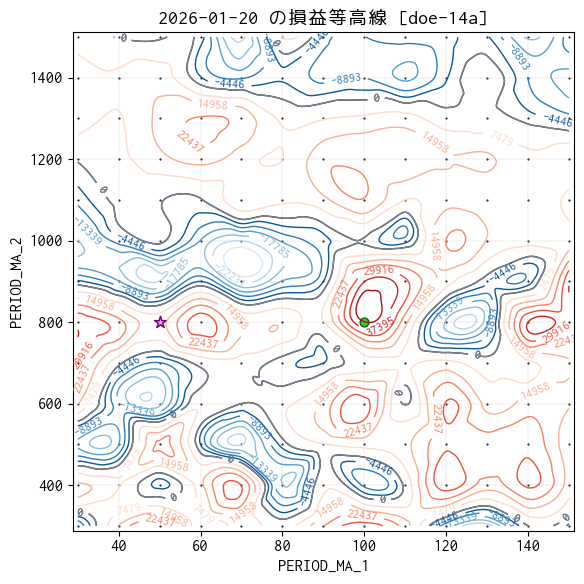

In [182]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

try:
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

try:
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

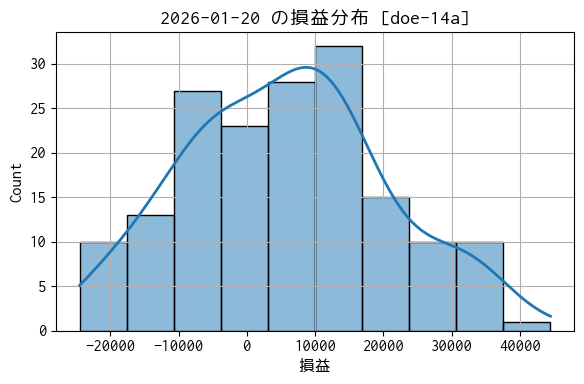

In [183]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [{name_doe}]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [184]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                     file  code  trade     total  PERIOD_MA_1  PERIOD_MA_2
2731  ticks_20260116.xlsx  285A    100  106500.0           40          500

最低損益
                     file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
2965  ticks_20260119.xlsx  285A     98 -80000.0           40         1000


## 日付 × 条件 で損益を集計

In [185]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
                0        1        2        3        4        5        6    \
2025-12-19 -19900.0  -3600.0 -16500.0 -23600.0 -34000.0 -35500.0 -19000.0   
2025-12-22 -15000.0  -1500.0 -24600.0 -33700.0  -9800.0 -16900.0 -11700.0   
2025-12-23 -24000.0 -21900.0 -20700.0  -5200.0  -8200.0  -1400.0 -19800.0   
2025-12-24   7000.0   4500.0  30500.0  -4000.0  16500.0  13000.0   1000.0   
2025-12-25  -8500.0 -21500.0 -33000.0  -6000.0 -31500.0  27500.0  12000.0   
2025-12-26 -49500.0 -26000.0  -7000.0 -36500.0 -13500.0  -4500.0  -1000.0   
2025-12-29 -40500.0 -42500.0 -32000.0 -35500.0 -23000.0 -30500.0 -27500.0   
2025-12-30  -1500.0 -13500.0  -9000.0  -6500.0   -500.0  -8000.0  -5000.0   
2026-01-05 -42000.0 -30500.0 -48000.0 -56500.0 -27500.0 -53000.0 -40500.0   
2026-01-06   7000.0 -28000.0  -9500.0 -12500.0  -9500.0  12500.0 -21000.0   
2026-01-07 -22500.0   2500.0 -11500.0   6000.0  17000.0  45500.0  32000.0   
2026-01-08      0.0 -36000.0 -12500.0 -15500.0 -13000.0 

## 損益の移動平均のトレンド

In [186]:
# 移動平均
df_ma = df_raw.rolling(window=period, min_periods=1).mean()
print(df_ma)
# データスコープを示す文字列
dt_start = df_ma.index[0]
dt_end = df_ma.index[-1]
title_scope = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {dt_start.date()} to {dt_end.date()} / "
    f"n={n_day}d / "
    f"rolling={period}d"
)
print("データスコープを示す文字列")
print(title_scope)

                     0             1             2             3    \
2025-12-19 -19900.000000  -3600.000000 -16500.000000 -23600.000000   
2025-12-22 -17450.000000  -2550.000000 -20550.000000 -28650.000000   
2025-12-23 -19633.333333  -9000.000000 -20600.000000 -20833.333333   
2025-12-24 -12975.000000  -5625.000000  -7825.000000 -16625.000000   
2025-12-25 -12080.000000  -8800.000000 -12860.000000 -14500.000000   
2025-12-26 -18316.666667 -11666.666667 -11883.333333 -18166.666667   
2025-12-29 -21485.714286 -16071.428571 -14757.142857 -20642.857143   
2025-12-30 -18987.500000 -15750.000000 -14037.500000 -18875.000000   
2026-01-05 -21544.444444 -17388.888889 -17811.111111 -23055.555556   
2026-01-06 -18690.000000 -18450.000000 -16980.000000 -22000.000000   
2026-01-07 -19036.363636 -16545.454545 -16481.818182 -19454.545455   
2026-01-08 -17450.000000 -18166.666667 -16150.000000 -19125.000000   
2026-01-09 -12646.153846 -14769.230769 -11369.230769 -15500.000000   
2026-01-13 -12171.42

### ランキング（移動平均）

In [187]:
# 最終日の移動平均収益のランキング
ser_ma_ranking = df_ma.iloc[len(df_ma) - 1].sort_values(ascending=False)
n_top = 5

# ベスト条件の抽出
best_ma_conditions = list(ser_ma_ranking.index[:n_top])
df_ma_best = df_latest.iloc[best_ma_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_ma.index[-1]
df_ma_best["損益(MA)"] = (df_ma.loc[dt:][best_ma_conditions].T)[dt]
print("---\n[Best Conditions with latest MA]")
print(df_ma_best)

# HTML 形式で出力
styled = (
    df_ma_best.style.format(
        {
            col_x: "{:.1f}",
            col_y: "{:.1f}",
            "取引回数": "{:.0f}",
            "損益": "{:.1f}",
            "損益(MA)": "{:.1f}",
        }
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_ma_conditions = ser_ma_ranking[ser_ma_ranking < 0].index
if len(negative_ma_conditions) > 0:
    df_ma_negative = df_latest.iloc[negative_ma_conditions].copy()
    df_ma_negative["損益(MA)"] = (df_ma.loc[dt:][negative_ma_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MA]")
    print(df_ma_negative)

---
[Best Conditions with latest MA]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益       損益(MA)
7            100          300    78  33500.0  6136.842105
144           40         1400    48   8500.0  5726.315789
42            60          600    90   6000.0  5715.789474
45            90          600    68  17000.0  4473.684211
35           120          500    56  28000.0  3536.842105
---
[Bad Conditions with latest MA]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益 備考       損益(MA)
145           50         1400    48  11500.0       -5.263158
143           30         1400    54  11500.0      -31.578947
123           90         1200    40  19500.0      -42.105263
27            40          500   100 -13500.0      -42.105263
68            60          800    58  34500.0     -173.684211
..           ...          ...   ...      ... ..          ...
59           100          700    54   4500.0    -7463.157895
147           70         1400    46  -9500.0    -8252.631579
13            30          400 

### 条件毎の損益トレンド（移動平均）のチャート

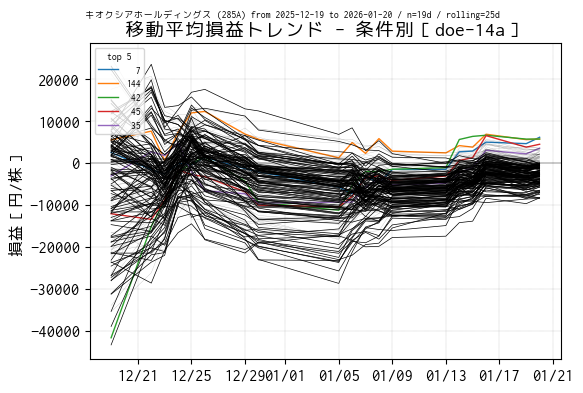

In [188]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_ma[dt_from <= df_ma.index]

for colname in ser_ma_ranking.index:
    if colname in best_ma_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_ma_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動平均損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_ma_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 損益の移動メジアンのトレンド

In [189]:
# 移動メジアン
df_mm = df_raw.rolling(window=period, min_periods=1).median()
print(df_mm)

                0        1        2        3        4        5        6    \
2025-12-19 -19900.0  -3600.0 -16500.0 -23600.0 -34000.0 -35500.0 -19000.0   
2025-12-22 -17450.0  -2550.0 -20550.0 -28650.0 -21900.0 -26200.0 -15350.0   
2025-12-23 -19900.0  -3600.0 -20700.0 -23600.0  -9800.0 -16900.0 -19000.0   
2025-12-24 -17450.0  -2550.0 -18600.0 -14400.0  -9000.0  -9150.0 -15350.0   
2025-12-25 -15000.0  -3600.0 -20700.0  -6000.0  -9800.0  -1400.0 -11700.0   
2025-12-26 -17450.0 -12550.0 -18600.0 -14800.0 -11650.0  -2950.0  -6350.0   
2025-12-29 -19900.0 -21500.0 -20700.0 -23600.0 -13500.0  -4500.0 -11700.0   
2025-12-30 -17450.0 -17500.0 -18600.0 -15050.0 -11650.0  -6250.0  -8350.0   
2026-01-05 -19900.0 -21500.0 -20700.0 -23600.0 -13500.0  -8000.0 -11700.0   
2026-01-06 -17450.0 -21700.0 -18600.0 -18050.0 -11650.0  -6250.0 -15350.0   
2026-01-07 -19900.0 -21500.0 -16500.0 -12500.0  -9800.0  -4500.0 -11700.0   
2026-01-08 -17450.0 -21700.0 -14500.0 -14000.0 -11400.0  -5250.0  -8350.0   

### ランキング（移動メジアン）

In [190]:
# 最終日の移動メジアン収益のランキング
ser_mm_ranking = df_mm.iloc[len(df_mm) - 1].sort_values(ascending=False)
n_top = 10

# ベスト条件の抽出
best_mm_conditions = list(ser_mm_ranking.index[:n_top])
df_mm_best = df_latest.iloc[best_mm_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_mm.index[-1]
df_mm_best["損益(MM)"] = (df_mm.loc[dt:][best_mm_conditions].T)[dt]
print("---\n[Best Conditions with latest MM]")
print(df_mm_best)

# HTML 形式で出力
styled = (
    df_mm_best.style.format(
        {
            col_x: "{:.1f}",
            col_y: "{:.1f}",
            "取引回数": "{:.0f}",
            "損益": "{:.1f}",
            "損益(MM)": "{:.1f}",
        }
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_mm_conditions = ser_mm_ranking[ser_mm_ranking < 0].index
if len(negative_mm_conditions) > 0:
    df_mm_negative = df_latest.iloc[negative_mm_conditions].copy()
    df_mm_negative["損益(MM)"] = (df_mm.loc[dt:][negative_mm_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MM]")
    print(df_mm_negative)

---
[Best Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益  損益(MM)
42            60          600    90   6000.0  6000.0
144           40         1400    48   8500.0  5500.0
28            50          500   100  24000.0  5000.0
153          130         1400    30   4000.0  4000.0
145           50         1400    48  11500.0  4000.0
9            120          300    70 -13000.0  3900.0
67            50          800    74  12000.0  3600.0
154          140         1400    32  -9000.0  3500.0
90           150          900    34  36500.0  2800.0
131           40         1300    60   7000.0  2800.0
---
[Bad Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益 備考   損益(MM)
35           120          500    56  28000.0      -200.0
55            60          700    86   2500.0      -300.0
92            40         1000    72  -6500.0      -400.0
155          150         1400    30 -14500.0      -400.0
167          140         1500    32 -18500.0      -500.0
..

### 条件毎の損益トレンド（移動メジアン）のチャート

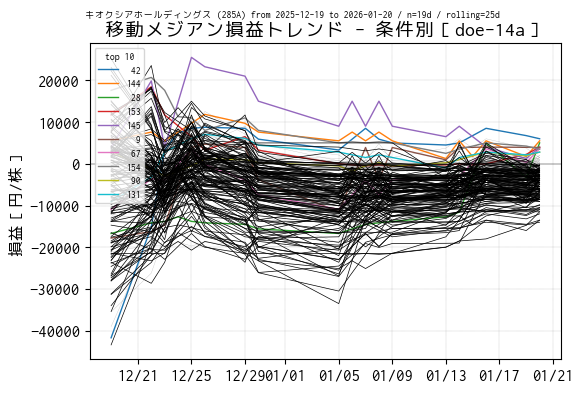

In [191]:
# ---------------------------------------------------------
# 実験条件毎の平均メジアントレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

df_trend = df_mm[dt_from <= df_mm.index]

for colname in ser_mm_ranking.index:
    if colname in best_mm_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_mm_conditions:  # 最新のメジアン収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動メジアン損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_mm_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

IndexError: index -25 is out of bounds for axis 0 with size 19

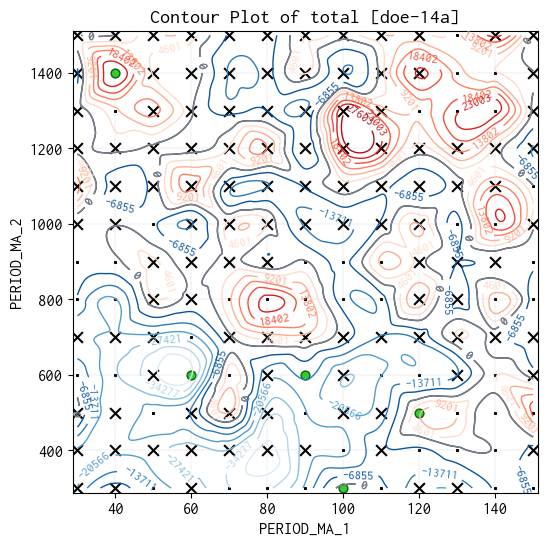

In [192]:
n = len(df_doe) * period
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "total"
x = df[col_x][-n:]
y = df[col_y][-n:]
z = df[col_z][-n:]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"Contour Plot of total [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_ma_best[col_x],
    df_ma_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
if len(negative_ma_conditions) > 0:
    ax.scatter(
        df_ma_negative[col_x],
        df_ma_negative[col_y],
        marker="x",
        color="black",
        s=60,
        zorder=1,
    )

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

title_scope_2 = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {df_ma.index[-period].date()} to {dt_end.date()}, {period} days"
)

plt.suptitle(title_scope_2, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()